# Prediction pipeline


1. perspective correction
2. for each perspective corrected image: patches
3. for each patch: predict
4. sew patches back together
5. Maybe: put together perspective corrected img


### Imports

In [93]:
import os
import sys
import cv2
import numpy as np
import glob
import json
import patchify
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras

### Options

In [136]:
target_dir = './perspective-correction-test/input_targets'
image_size = (5760, 2880)
patch_size = 480
rect_height = patch_size * 4 # 1920
rect_width  = patch_size * 2 # 960 so one 5760px image fits in 5760 / 960 = 6 rectangles
equ_correction_steps = image_size[0] // rect_width
model_path = './2021-12-31-light-augments-val-loss-0_085'

### Perspective correction

In [20]:

def printr(value):
    print(value, end="")
    print('\r', end="")


class Equirectangular:
    def __init__(self, img_name):
        self._img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        [self._height, self._width, _] = self._img.shape
    

    def GetPerspective(self, FOV=0, THETA=0, PHI=0, height=0, width=0):
        #
        # THETA is left/right angle, PHI is up/down angle, both in degree
        #

        equ_h = self._height
        equ_w = self._width
        equ_cx = (equ_w - 1) / 2.0
        equ_cy = (equ_h - 1) / 2.0

        wFOV = FOV
        hFOV = float(height) / width * wFOV

        w_len = np.tan(np.radians(wFOV / 2.0))
        h_len = np.tan(np.radians(hFOV / 2.0))


        x_map = np.ones([height, width], np.float32)
        y_map = np.tile(np.linspace(-w_len, w_len,width), [height,1])
        z_map = -np.tile(np.linspace(-h_len, h_len,height), [width,1]).T

        D = np.sqrt(x_map**2 + y_map**2 + z_map**2)
        xyz = np.stack((x_map,y_map,z_map),axis=2)/np.repeat(D[:, :, np.newaxis], 3, axis=2)
        
        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        z_axis = np.array([0.0, 0.0, 1.0], np.float32)
        [R1, _] = cv2.Rodrigues(z_axis * np.radians(THETA))
        [R2, _] = cv2.Rodrigues(np.dot(R1, y_axis) * np.radians(-PHI))

        xyz = xyz.reshape([height * width, 3]).T
        xyz = np.dot(R1, xyz)
        xyz = np.dot(R2, xyz).T
        lat = np.arcsin(xyz[:, 2])
        lon = np.arctan2(xyz[:, 1] , xyz[:, 0])

        lon = lon.reshape([height, width]) / np.pi * 180
        lat = -lat.reshape([height, width]) / np.pi * 180

        lon = lon / 180 * equ_cx + equ_cx
        lat = lat / 90  * equ_cy + equ_cy

        
            
        persp = cv2.remap(self._img, lon.astype(np.float32), lat.astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)
        return persp

    
def perspective_correction(input_path, output_folder, steps=6):
    """
    FOV unit is degree
    theta is z-axis angle(right direction is positive, left direction is negative)
    phi is y-axis angle(up direction positive, down direction negative)
    height and width is output image dimension
    """
    
    filename = input_path.split("/")[-1].split(".")[:-1][0]
    if output_folder[-1] == '/':
        output_folder = output_folder[:-1]

    equ = Equirectangular(input_path)

    step = 360 // steps
    filepaths = []
    for i in range(0, 360, step):
        img = equ.GetPerspective(FOV=step, THETA=i, PHI=0, height=rect_height, width=rect_width)
        i_str = str(i).zfill(3)
        i_step_str = str(i+step).zfill(3)
        output = f'{output_folder}/{filename}_{i_str}-{i_step_str}.png'
        cv2.imwrite(output, img)
        filepaths.append(output)
    return filepaths
        

### Make patches

In [77]:
        
def create_patches_prime(filepath):
    img = Image.open(filepath)
    patches_in_column = rect_height // patch_size
    patches_in_row = rect_width // patch_size
    img_patched = patchify.patchify(np.asarray(img), (patch_size, patch_size, 3), step=patch_size).reshape(patches_in_column * patches_in_row, patch_size, patch_size, 3)
    filepaths = []
    for i in range(0, img_patched.shape[0]):
        outfilepath = f'{".".join(filepath.split(".")[:-1])}-{str(i).zfill(2)}.npz'
        np.savez_compressed(outfilepath, img_patched[i])
        filepaths.append(outfilepath)
    return filepaths

def create_patches(perspective_corrected_filepaths):
    npz_filepaths = []
    for perspective_corrected_filepath in perspective_corrected_filepaths:
        npz_filepaths_prime = create_patches_prime(perspective_corrected_filepath)
        npz_filepaths += npz_filepaths_prime
    return npz_filepaths


# Predict

In [137]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs=[], batch_size=2):
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        
        
    def __len__(self):
        n_items = len(self.list_IDs)
        at_least = n_items // self.batch_size
        if n_items % self.batch_size == 0:
            return at_least
        return at_least + 1
    
    def __getitem__(self, index):
        start = self.batch_size * index
        end = self.batch_size * (index + 1)
        IDs = self.list_IDs[start:end]
        np_arrs = [np.load(arr)['arr_0'] / 255 for arr in IDs]
        return np_arrs
    
    
def predict_with(model, batch_size):
    def predict(npz_filepaths):
        gen = DataGenerator(batch_size=batch_size, list_IDs=npz_filepaths)
        results = model.predict(gen)
        return results
    return predict


def run_pipeline(target_folder, temp_folder_name='temp'):
    # normalize target folder
    if target_folder[-1] == '/':
        target_folder = target_folder[:-1]

    # create temp folder
    target_folder_split = target_folder.split("/")
    target_folder_parent = "/".join(target_folder_split[:-1])
    output_folder = f'{target_folder_parent}/{temp_folder_name}'
    if temp_folder_name not in os.listdir(target_folder_parent):
        os.mkdir(output_folder)

    # setup
    filenames = [filename for filename in os.listdir(target_folder) if '.JPG' in filename]
    filenames_n = len(filenames)
    filenames_digits = len(str(filenames_n))
    model = keras.models.load_model(model_path)
    precict = predict_with(model)
    
    # The Pipeline
    print(f'Total number of files: {filenames_n}')
    printr(f'Done: {"0".zfill(filenames_digits)}/{filenames_n}')
    for i, filename in enumerate(filenames):
        full_path = f'{target_dir}/{filename}'
        perspective_corrected_filepaths = perspective_correction(full_path, output_folder)
        patched_npzs = create_patches(perspective_corrected_filepaths)
        predictions = predict(model, patched_npzs)
        printr(f'Done: {str(i+1).zfill(filenames_digits)}/{filenames_n}')
    print('Done!')
    
run_pipeline(target_dir)

ModuleNotFoundError: No module named 'keras.engine.base_layer_v1'

In [128]:
testnames = [f'{tempfolder}/{npz}' for npz in os.listdir(tempfolder) if '.npz' in npz][:8]
datagen = DataGenerator(batch_size=5, list_IDs=testnames)
gen = datagen.__iter__()

In [131]:
X = next(gen)

5 10 1 ['./perspective-correction-test/temp/20210914-kruununhaka_GSAD0220_060-120-03.npz', './perspective-correction-test/temp/20210914-kruununhaka_GSAD0170_060-120-05.npz', './perspective-correction-test/temp/20210914-kruununhaka_GSAD0170_060-120-04.npz', './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220_060-120-02.npz', './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220_060-120-00.npz', './perspective-correction-test/temp/20210914-kruununhaka_GSAD0170_060-120-06.npz', './perspective-correction-test/temp/20210914-kruununhaka_GSAD0170_060-120-07.npz', './perspective-correction-test/temp/20210914-kruununhaka_GSAD0220_060-120-01.npz']


In [132]:
print(len(X))
X[0].shape

3


(480, 480, 3)

### Tests

patchify

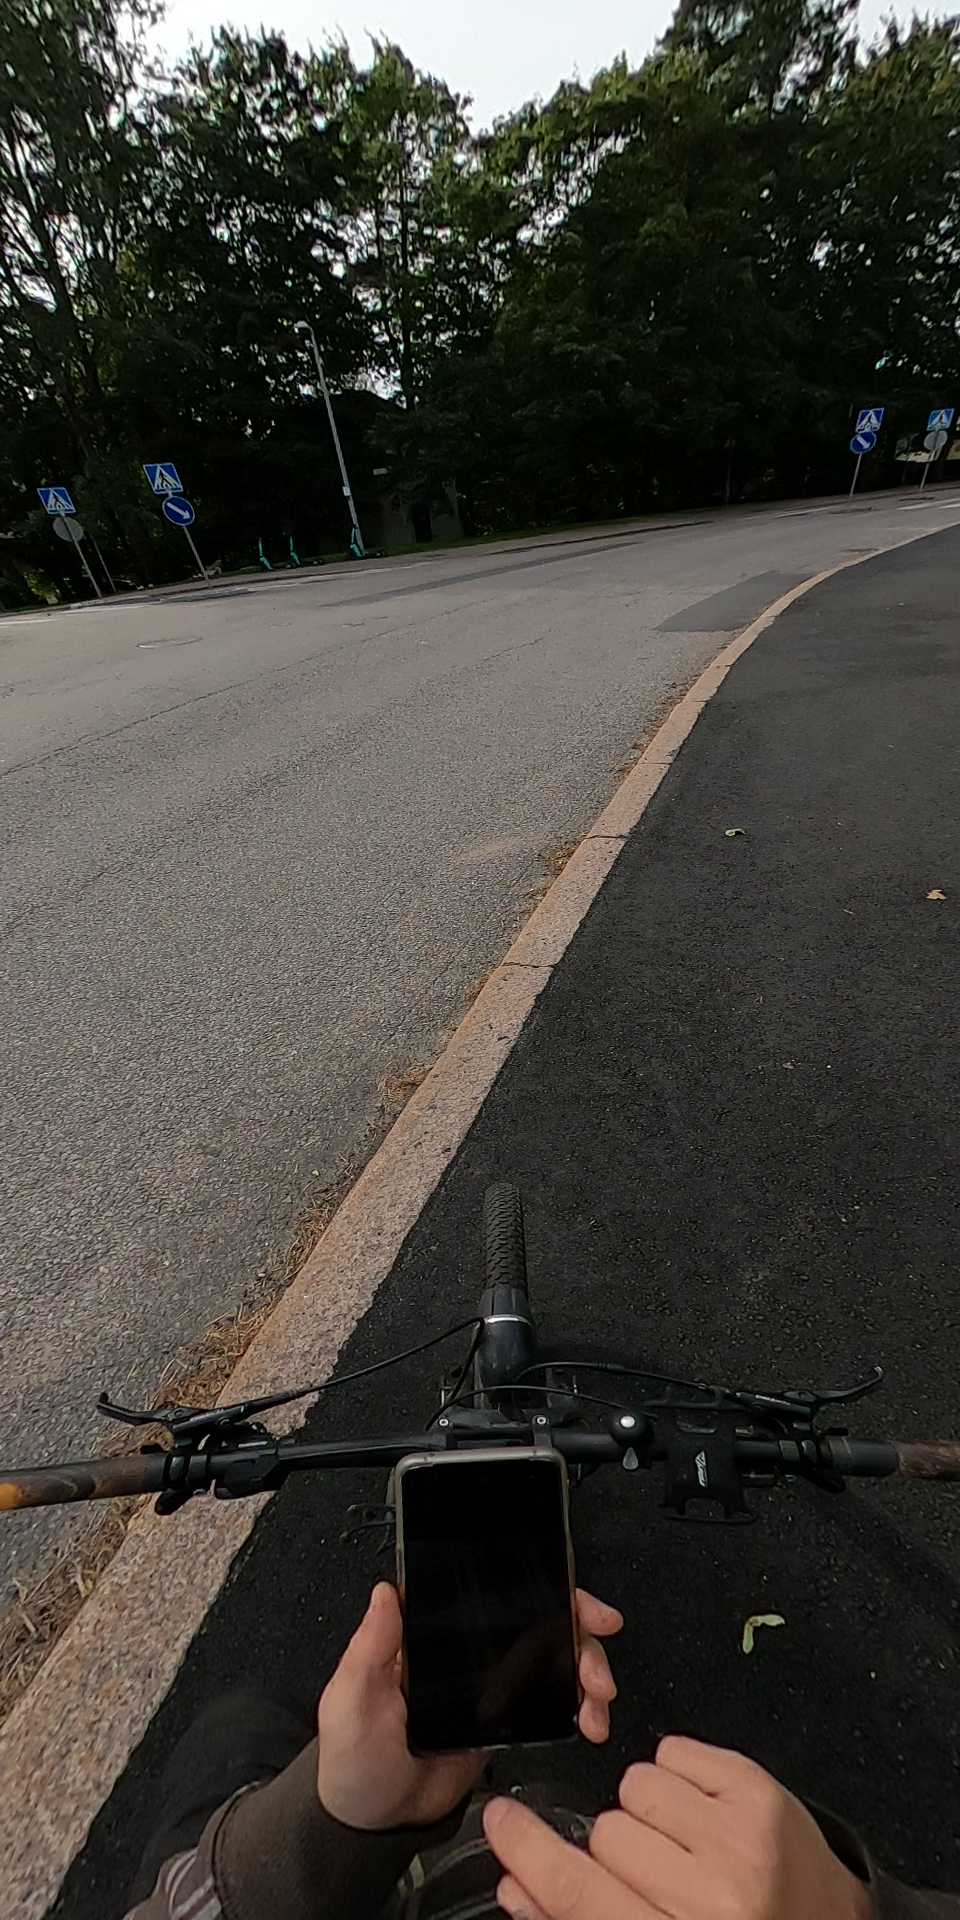

In [70]:
tempfolder = './perspective-correction-test/temp' 
testimage_name = '20210914-kruununhaka_GSAD0170_000-060.png'
Image.open(f'{tempfolder}/{testimage_name}')

0
1
2
3
4
5
6
7


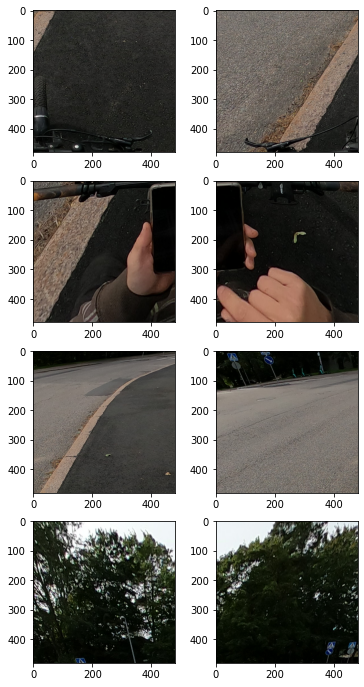

In [85]:
patches = [np.load(f'{tempfolder}/{npz}')['arr_0'] for npz in os.listdir(tempfolder) if '.npz' in npz and '.'.join(testimage.split('.')[:-1]) in npz]


n_rows = 4
n_columns = 2
fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*3, n_rows*3))
for i in range(0, n_rows):
    for j in range(0, n_columns):
        idx = i*n_columns + j
        axs[i][j].imshow(patches[idx])

In [31]:
filepath = '.perspective-correction-test/some-file.png'
i=0

In [32]:
f'{".".join(filepath.split(".")[:-1])}-{str(i).zfill(2)}.npz'

'perspective-correction-test/some-file-00.npz'

In [13]:
5760/480

12.0

In [14]:
5760 / 6

960.0

In [15]:
1920 / 480

4.0